# Bike sharing demand - initial data exploration

## Download dataset from kaggle
Navigate to https://www.kaggle.com. Then go to the Account tab of your user profile and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials. Run the cell and upload this file.

In [ ]:
!pip install kaggle

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c bike-sharing-demand
!unzip bike-sharing-demand.zip

## Preprocess data

Read data and check that there are no missing values

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('train.csv')
print(df.info(verbose=True, show_counts=True))
df.head()

Rename count to total to avoid conflict with builtin count

In [ ]:
df = df.rename({'count': 'total'}, axis=1)
df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Split datetime column into individual parts to make them interpretable

In [ ]:
df['year'] = pd.DatetimeIndex(df.datetime).year
df['month'] = pd.DatetimeIndex(df.datetime).month
df['day'] = pd.DatetimeIndex(df.datetime).day
df['hour'] = pd.DatetimeIndex(df.datetime).hour
df['dayofweek'] = pd.DatetimeIndex(df.datetime).dayofweek
df = df.drop("datetime", axis=1)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,year,month,day,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


Check that 'total' is indeed 'registered' + 'casual'

In [ ]:
diff = df['total'] - df['registered'] - df['casual']
diff.unique()

array([0])

9 Categorical features:
- **season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- **holiday** - whether the day is considered a holiday
- **workingday** - whether the day is neither a weekend nor holiday
- **weather** 
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- **year** - 2011 or 2012
- **month** - January=1, December=12.
- **day** - 1 to 31
- **hour** - 0 to 23
- **dayofweek** - monday=0, sunday=6

4 Continuous features:
- **temp** - temperature in Celsius
- **atemp** - "feels like" temperature in Celsius
- **humidity** - relative humidity
- **windspeed** - wind speed

3 Targets:
- **casual** - number of non-registered user rentals initiated
- **registered** - number of registered user rentals initiated
- **total** - number of total rentals: sum of casual and registered

Log transform the target variables because the distributions are heavily skewed

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


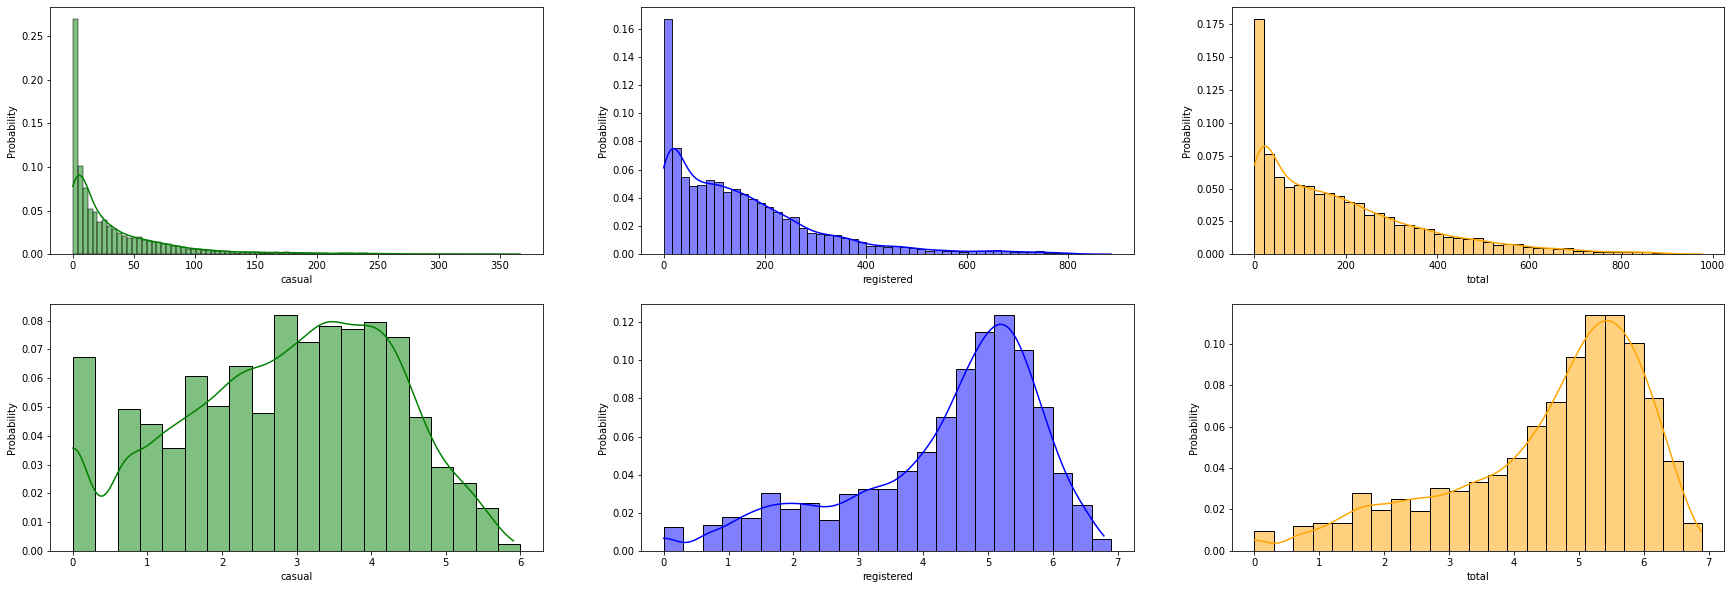

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(30,10))
colors=['green', 'blue', 'orange']
targets = ['casual', 'registered', 'total']
for i, t in enumerate(targets):
  sns.histplot(df[t], ax=ax[0][i], stat='probability', kde=True, color=colors[i])
  sns.histplot(np.log(df[t]), ax=ax[1][i], stat='probability', kde=True, color=colors[i], binwidth=0.3)

Plot heatmap to show feature correlations. Some findings:
- temp and atemp have almost perfect correlation, so one can be dropped
- month and season have an almost perfect correlation, so season could potentially be dropped
- temp has positive correlation with total (+0.37) and registered (0.33), and especially casual (+0.53)
- hour has positive correlation with total (+0.57), registered (+0.57) and a bit less with casual (+0.42)
- humidity has negative correlation with total
- dayofweek and workingday have positive and negative correlation with casual respectively, but do not influence registered much
- season has some positive correlation with all targets
- humidity has negative correlation with all targets
- windspeed, year and month have slight positive correlation with all targets
- holiday and day have little correlation with any target

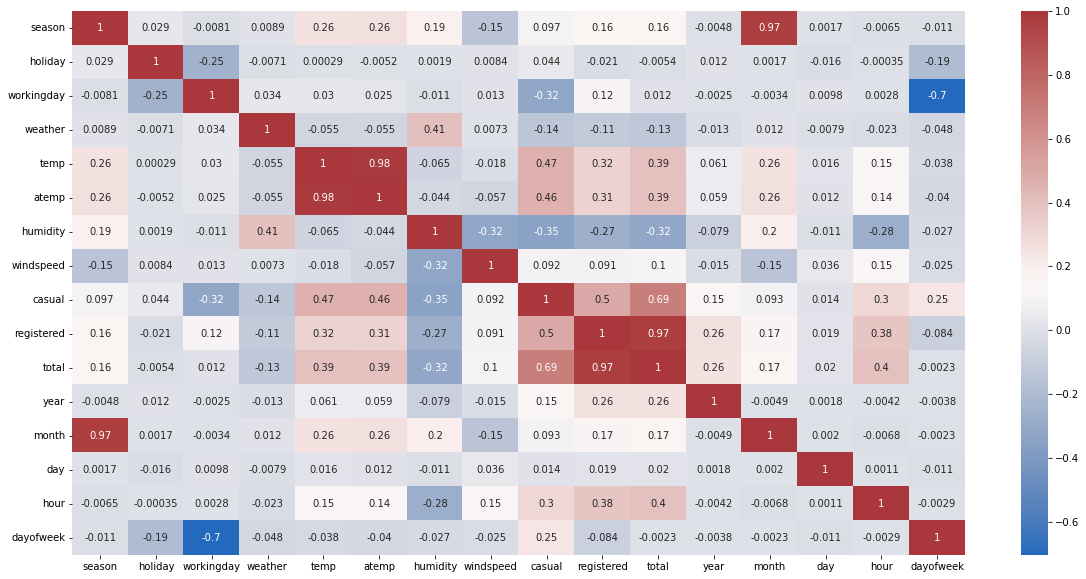

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True, cmap='vlag');

Workingday can also be dropped since it is just a combination of dayofweek and holiday

Is workingday a combination of dayofweek and holiday?


True

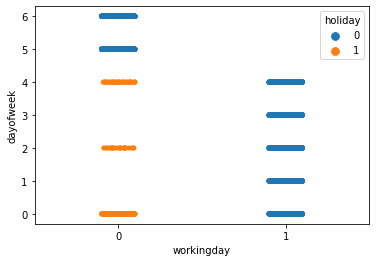

In [ ]:
sns.stripplot(data=df, y='dayofweek', x='workingday', hue='holiday')
print('Is workingday a combination of dayofweek and holiday?')
df['workingday'].eq((df['dayofweek'].astype('int') <= 4) & (df['holiday'] == 0)).all()

In [ ]:
# categorical = ['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'day', 'hour', 'dayofweek']
# for ft in categorical:
#   df[ft] = df[ft].astype('category')

# print(df.info(verbose=True, show_counts=True))

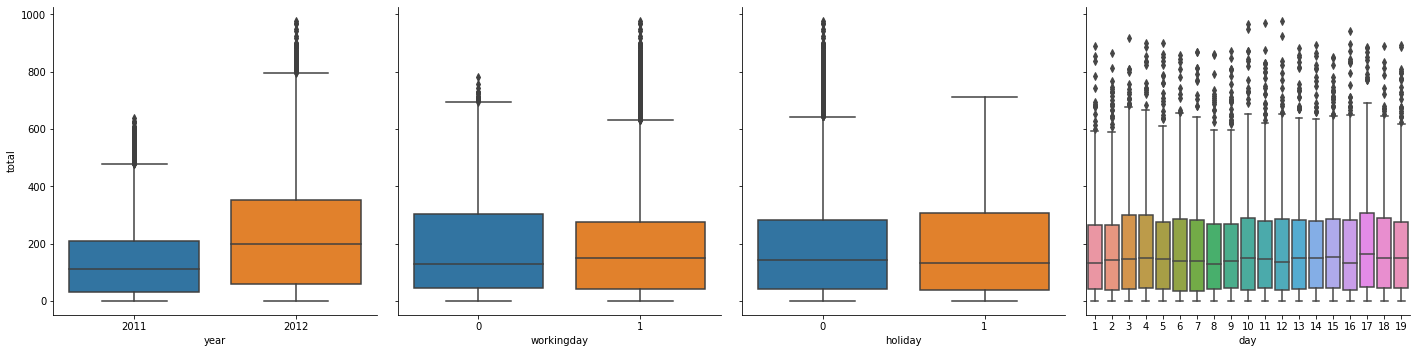

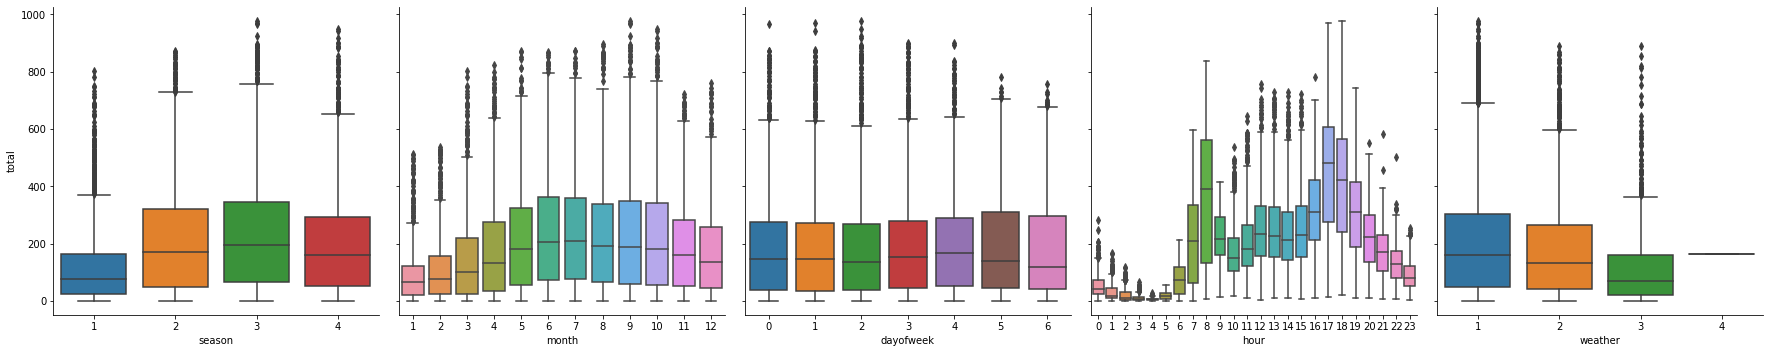

In [ ]:
sns.PairGrid(df, y_vars=['total'], x_vars=["year", "workingday", "holiday", "day"], height=5).map(sns.boxplot);
sns.PairGrid(df, y_vars=['total'], x_vars=["season", "month", "dayofweek", "hour", "weather"], height=5).map(sns.boxplot);

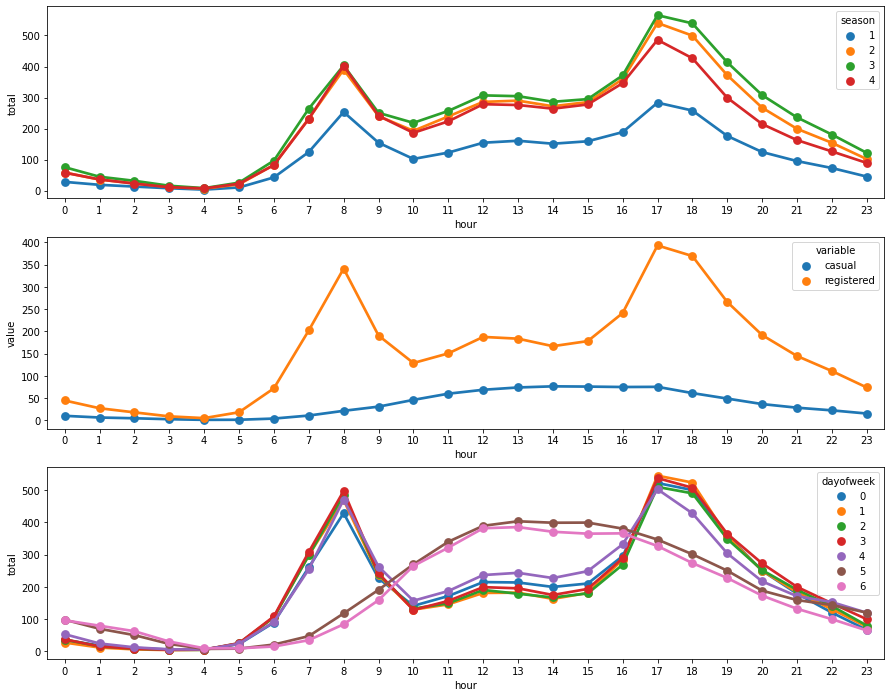

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(15,12))
aggr = df.groupby(['hour', 'season'], as_index=False).mean()
sns.pointplot(x=aggr.hour, y=aggr.total, hue=aggr.season, ax=ax[0])

aggr = df.melt(id_vars=['hour'], value_vars=['registered', 'casual']).groupby(['hour', 'variable'], as_index=False).mean()
sns.pointplot(x=aggr.hour, y=aggr.value, hue=aggr.variable, ax=ax[1])

aggr = df.groupby(['hour', 'dayofweek'], as_index=False).mean()
sns.pointplot(x=aggr.hour, y=aggr.total, hue=aggr.dayofweek, ax=ax[2]);


Observations:  

1.   We can see a clear bimodal trend in both the second and the third plot: 
  * During weekdays, the peak of bike rental time is around 8:00am and around 17:00pm to 18:00pm (rush hours)
  * The peak of bike rental time for registered riders is also around 8:00am and around 17:00pm to 18:00pm (rush hours)
  
2.   During weekends, the plot is unimodal: the peak of bike rental time is around 11am to 16pm  






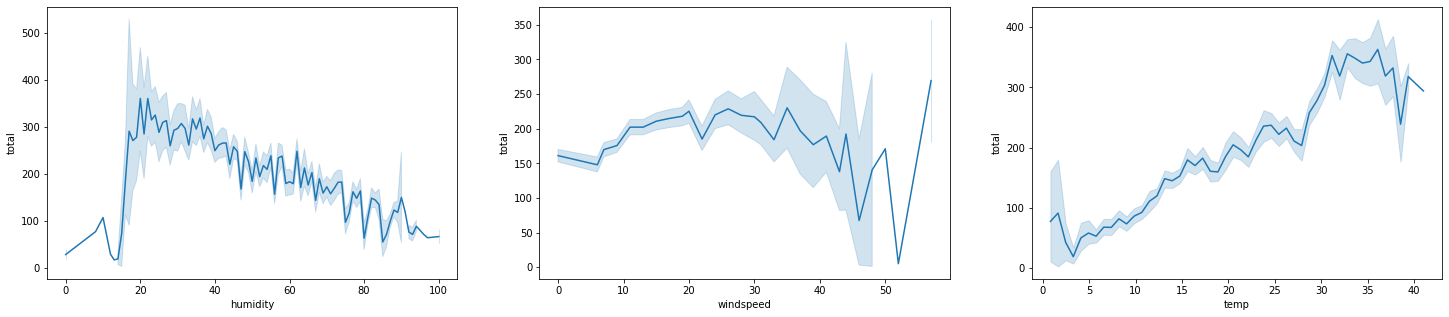

In [ ]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(25,5)
sns.lineplot(data=df, x="humidity", y="total", ax=axs[0])
sns.lineplot(data=df, x="windspeed", y="total", ax=axs[1])
sns.lineplot(data=df, x="temp", y="total", ax=axs[2])


Observations:
1. Higher humidity, lower bike rentals in total generally speaking, but if humidity is under 20, we can see a big drop
2. Windspeed generally don't influence bike rentals, but we can see a big drop occur when windspeed is around 50 
3. Higher tempreture, higher bike rentals in total

Weather seems to influence bike rentals a lot (higher rentals if the weather is good, i.e., humidity around 20 and tempreture around 30 to 35 °C)

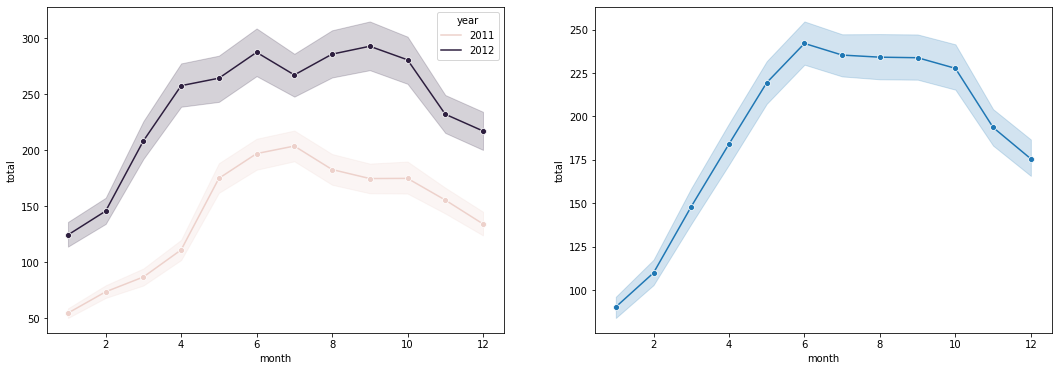

In [ ]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(18,6)
sns.lineplot(data=df, x="month", y="total", marker='o', hue="year", ax=axs[0])
sns.lineplot(data=df, x="month", y="total", marker='o', ax=axs[1])

Observations:
1. Peak of bike rentals occur starting in June and ending in October
2. More bike rentals in 2012 than in 2011